# Graph theory with PowerShell

# Table of contents
* ## [Directed graphs](#directed)
* ## [Undirected graphs](#undirected)
* ## [Connected graphs](#connected)
   * ### [Complete graphs](#complete)
   * ### [Random graphs](#random)
   * ### [Probability of connectivity](#connectivity)

When I try to learn a new technical topic it is easier for me to do/experience the new topic through a technology I already know about. That's why I perfer to play around with things in PowerShell even though there might be better ways of doing the same using another technology. 

In this post I'm going to explore a bit of graph theory based on chapter 2 of the execellent book "[Think Complexity 2e](https://greenteapress.com/wp/think-complexity-2e/)" by Allen B. Downey (in fact I'd highly recommend any of the books in the "Think..." series some of which I might cover in future posts). The book and the book's source (in Python) are available for free through the book's webpage.
[Graph theory](https://en.wikipedia.org/wiki/Graph_theory) is the study of graphs, which are mathematical structures used to model pairwise relations between objects. A graph is made up of vertices (also called nodes or points) which are connected by edges (also called links or lines). Since networks are everywhere, graph theory is everywhere, too.  Graph theory is used to model and study all kinds of things that affect our daily lives: from traffic routes to social networks or integrated circuits.

We will use the excellent [PSGraph](https://github.com/KevinMarquette/PSGraph) module developed by Keven Marquette for visualizing the graphs. PSGraph is a wrapper around [Graphviz](https://graphviz.org/) which is a commandline utility for displaying graphs. We will need to install both PSGraph and Graphviz.

In [ ]:
# install Chocolatey
[System.Net.ServicePointManager]::SecurityProtocol = [System.Net.ServicePointManager]::SecurityProtocol -bor
[System.Net.SecurityProtocolType]::Tls12
Invoke-RestMethod -UseBasicParsing -Uri 'https://chocolatey.org/install.ps1' | Invoke-Expression
# use chocolatey to install graphviz
cinst graphviz -
# install PSgraph
Install-Module PSGraph

For some reason the command to export and show the Graph (Show-PSGraph) did not work on my machine. Therefore I've written my own version of the command which will overwrite the version that comes with the PSGraph module after importing it.

In [2]:
Import-Module PSGraph
function Show-PSGraph ([ValidateSet('dot', 'circular', 'Hierarchical', 'Radial', 'fdp', 'neato', 'sfdp', 'SpringModelLarge', 'SpringModelSmall', 'SpringModelMedium', 'twopi')]$LayoutEngine = 'circular') {
    $all = @($Input)
    $tempPath = [System.IO.Path]::GetTempFileName()
    $all | Out-File $tempPath
    $new = Get-Content $tempPath -raw | ForEach-Object { $_ -replace "`r", "" }
    $new | Set-Content -NoNewline $tempPath
    Export-PSGraph -Source $tempPath -ShowGraph -LayoutEngine $LayoutEngine
    Invoke-Item ($tempPath + '.png')
    Remove-Item $tempPath
}

To work through the examples we need some way to visualize the graph, which PSGraph will take care of. But we also need a way to represent a graph as an object. Let's setup some helper functions in order to do that.

In [3]:
function New-Edge ($From, $To, $Attributes, [switch]$AsObject) {
    $null = $PSBoundParameters.Remove('AsObject')
    $ht = [Hashtable]$PSBoundParameters
    if ($AsObject) {
        return [PSCustomObject]$ht
    }
    return $ht
}

function New-Node ($Name, $Attributes) {
    [Hashtable]$PSBoundParameters
}

function Get-GraphVisual ($Name, $Nodes, $Edges, [switch]$Undirected) {
    $sb = {
        if ($Undirected) { inline 'edge [arrowsize=0]' }
        foreach ($node in $Nodes) {
            node @node
        }
        foreach ($edge in $Edges) {
            edge @edge
        }
    }
    graph $sb
}

The logic of the above functions will get much clearer as we go.

Graphs are usually drawn with squares or circles for nodes (the things in the graph) and lines for edges (the connections between the things). Edges may be directed or undirected, depending on whether the relation-
ships they represent are asymmetric or symmetric.

## Directed graphs <a name="directed"></a>

A directed graph might represent three people who follow each other on Twitter. The arrow indicates the direction of the relationship. Let's create and draw our first graph using the helper functions. Grapviz/PSGraph takes care of the creation of nodes based on edges. This works fine if all nodes in a graph are connected.

In [ ]:
$edges = & {
    New-Edge Alice Bob
    New-Edge Alice Chuck
    New-Edge Bob Alice
    New-Edge Bob Chuck
}

Get-GraphVisual Friends -Edges $edges | Show-PSGraph

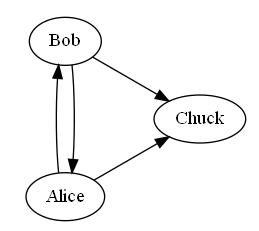

## Undirected graphs <a name="undirected"></a>

As an example of an undirected graph the below graph shows the connection between four cities in the United States. The labels on the edges indicate driving time in hours. In this example the placement of the nodes corresponds roughly to the geography of the cities, but in general the layout of a graph is arbitrary.
This time we will create node and edge objects since the position of the nodes is an attribute of a node rather than an edge. Edges  can also have labels assinged through the label attribute. We also need to switch the LayoutEngine since not every one of them honors the position attribute (see [here](https://observablehq.com/@magjac/placing-graphviz-nodes-in-fixed-positions)).

In [ ]:
$nodes = & {
    New-Node Albany @{ pos = '-74,43!' }
    New-Node Boston @{ pos = '-71,42!' }
    New-Node NYC @{ pos = '-74,41!' }
    New-Node Philly @{ pos = '-75,40!' }
}

$edges = & {
    New-Edge Albany Boston @{label = 3 }
    New-Edge Albany NYC @{label = 4 }
    New-Edge Boston NYC @{label = 4 }
    New-Edge NYC Philly @{label = 2 }
}


Get-GraphVisual Cities $nodes $edges -Undirected | Show-PSGraph -LayoutEngine neato

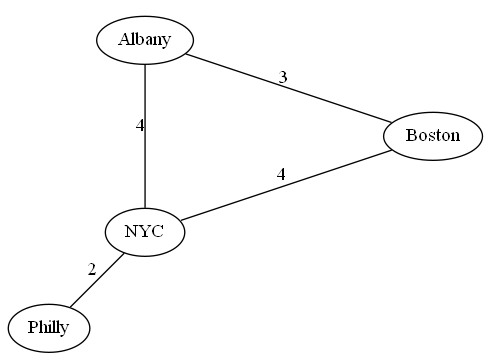

## Connected graphs <a name="connected"></a>

### Complete graphs <a name="complete"></a>

A complete graph is a graph where every node is connected to every other.
Let's create a function that draws a complete graph based on a list of Nodes. With this function we'll also start returning a Graph object with Nodes, Edges, and Visual properties.

In [4]:
function Get-CompleteGraph($Nodes) {
    $ht = [ordered]@{}
    $ht.Nodes = $Nodes
    $ht.Edges = for ($i = 0; $i -lt $Nodes.Count; $i++) {
        for ($j = 0; $j -lt $nodes.Count; $j++) {
            if ($i -lt $j) {
                New-Edge $Nodes[$i] $Nodes[$j] -AsObject
            }
        }
    }
    $ht.Visual = graph {
        inline 'edge [arrowsize=0]'
        edge $ht.Edges -FromScript { $_.To } -ToScript { $_.From }
    }
    [PSCustomObject]$ht
}

Let's just draw a complete graph with 10 nodes.

In [ ]:
$completeGraph = Get-CompleteGraph (0..9)
$completeGraph.Visual | Show-PSGraph

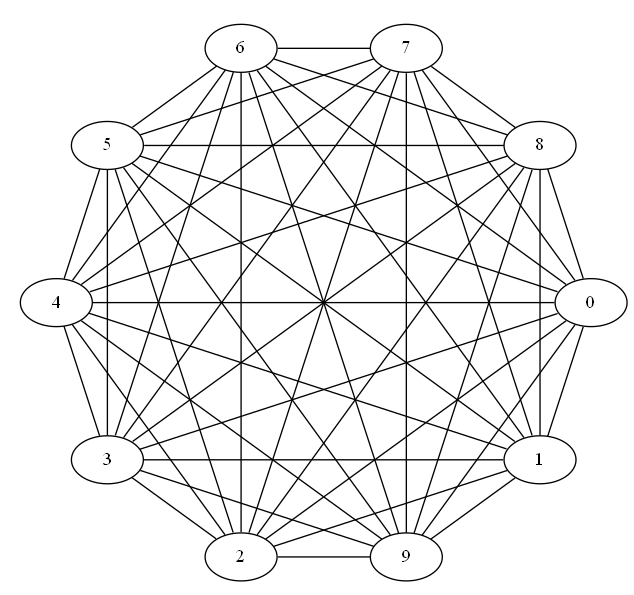

### Random graphs <a name="random"></a>

A random graph is just what it sounds like: a graph with nodes and edges generated at random. 

One of the more interesting kinds of random graphs is the Erdös-Renyi model, studied by Paul
Erdös and Alfred Renyi in the 1960s. An Erdös-Renyi graph (ER graph) is characterized by two parameters:
1. The number of nodes
2. The probability that there is an edge between any two nodes

Erdös and Renyi studied the properties of these random graphs; one of their surprising results is the existence of abrupt changes in the properties of random graphs as random edges are added. One of the properties that displays this kind of transition is connectivity (An undirected graph is connected if there is a path from every node to every other node.)

In an ER graph, the probability (p) that the graph is connected is very low when p is small and nearly 1 when p is large. 
Let's create a function that creates ER random graphs where the probability of an edge between each pair of nodes can be controlled  via the Probability parameter.

In [5]:
function Get-RandomGraph ($NodeCount, $Probability, [switch]$NoVisual) {
    $ht = [ordered]@{}
    $ht.Edges = for ($i = 0; $i -le $NodeCount - 1; $i++) {
        for ($j = 0; $j -le $NodeCount - 1; $j++) {
            if ($i -lt $j) {
                $rand = (Get-Random -Minimum 0 -Maximum 10000) / 10000
                if ($rand -lt $Probability) {
                    New-Edge $i $j -AsObject
                }
            }
        }
    }
    $ht.Nodes = 0..($NodeCount - 1)
    if (-not $NoVisual) {
        $ht.Visual = graph -Name Random {
            inline 'edge [arrowsize=0]'
            node $ht.Nodes
            edge $ht.Edges -FromScript { $_.From } -ToScript { $_.To }
        }
    }
    [PSCustomObject]$ht
}

Next we use the function to create a random Graph with 10 nodes and a Probability of edges between them of 30%.

In [7]:
$randomGraph = Get-RandomGraph 10 .3
$randomGraph.Visual | Show-PSGraph
$randomGraph.Edges.Count

13


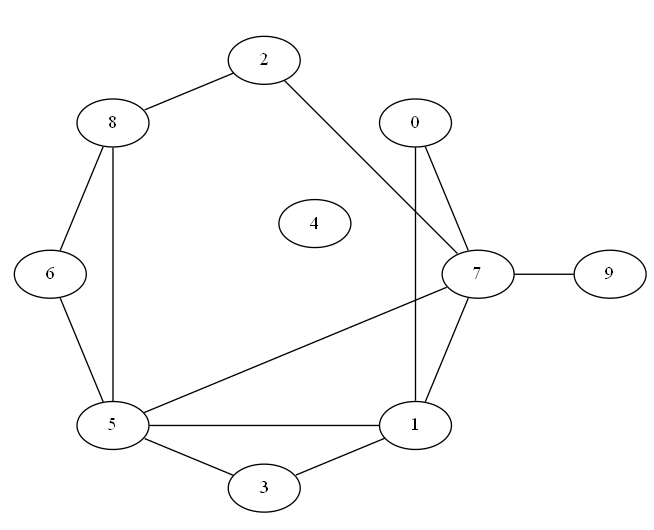

Remember? A graph is connected if there is a path from every node to every other node
For many applications involving graphs, it is useful to check whether a graph is connected. An algorithm that does this starts at any node and checks whether you can reach all other nodes. If a node can be reached, it implies, that you can also reach any of its neighbour nodes.
Below is a function that returns the neighbours of a given node by its name.

In [8]:
function Get-Neighbours ($Edges, $Name, [switch]$Undirected) {
    $edgeObjects = @($Edges)
    if (@($Edges)[0].GetType().FullName -ne 'System.Management.Automation.PSCustomObject') {
        $edgeObjects = foreach ($edge in $Edges) {
            [PSCustomObject]$edge
        }
    }
    (& {
            ($edgeObjects.where{ $_.From -eq $Name }).To
            if ($Undirected) {
                ($edgeObjects.where{ $_.To -eq $Name }).From
            }
        }).where{ ![String]::IsNullOrEmpty($_) }
}

Let's use it to find the neighbours of some nodes within the random- and completeGraph we created earlier:

In [10]:
Get-Neighbours $completeGraph.Edges 0

1
2
3
4
5
6
7
8
9


In [11]:
Get-Neighbours $randomGraph.Edges 2

7
8


With the Get-Neighbours function we can also create a function that iterates through a graph's nodes connected by edges and return the nodes that can be reached from a given start node. This is implemented through Get-ReachableNodes, where we use a Stack to collect the neighbours and a HashSet to keep track of "visited" nodes.

In [12]:
function Get-ReachableNodes ($Edges, $StartNode, [switch]$Undirected) {
    $seen = New-Object System.Collections.Generic.HashSet[string]
    $stack = New-Object System.Collections.Generic.Stack[string]
    $null = $stack.Push($StartNode)
    while ($stack.Count -gt 0) {
        $node = $stack.Pop()
        if (-not $seen.Contains($node)) {
            $null = $seen.Add($node)
            Get-Neighbours $Edges $node -Undirected:$Undirected | ForEach-Object {
                $null = $stack.Push( $_ )
            }
        }
    }
    return $seen
}

The last piece of the puzzle to check whether a graph is connected, is to use the Get-ReachableNodes function to get the set of nodes that can be reached from a giving starting point. If this number equals the number of nodes in the graph, that means we can reach all nodes, which means the graph is connected.

In [13]:
function Get-IsConnected($Graph, [switch]$Undirected) {
    if ($Graph.Edges.Count -eq 0) { return $false }
    $startNode = $Graph.Edges[0].From
    $reachable = Get-ReachableNodes $Graph.Edges $startNode -Undirected:$Undirected
    $reachable.Count -eq $Graph.Nodes.Count
}

Our complete graph is connected and our random graph happened to be not connected:

In [15]:
Get-IsConnected $completeGraph -Undirected

True


In [16]:
Get-IsConnected $randomGraph -Undirected

False


### Probability of connectivity <a name="connectivity"></a>

For given values number of nodes and probability, we would like to know the probability of the graph being connected. We can estimate this by generating a number of random graphs and counting how many are connected. 

In [18]:
function Get-ProbabilityConnected($NodeCount, $Probability, $Iterations = 100) {
    $count = 0
    for ($i = 0; $i -le $Iterations; $i++) {
        $randomGraph = Get-RandomGraph $NodeCount $Probability -Undirected -NoVisual
        if ((Get-IsConnected $randomGraph -Undirected )) { $count++ }
    }
    $count / $Iterations
}

In [19]:
$nodeCount = 10
Get-ProbabilityConnected $nodeCount .23 100

0.29


23% was chosen because it is close to the critical value where the probability of connectivity goes from near 0 to near 1. According to Erdös and Renyi.

In [20]:
[System.Math]::Log($nodeCount) / $nodeCount

0.230258509299405


We can get try to replicate transition by estimating the probability of connectivity for a range of values of probabilities. We implement Python's [numpy.Logspace](https://numpy.org/doc/stable/reference/generated/numpy.logspace.html) function to get an evenly spread list of probabilities within a range on a log scale:

In [21]:
function Get-LogSpace([Double]$Minimum, [Double]$Maximum, $Count) {
    $increment = ($Maximum - $Minimum) / ($Count - 1)
    for ( $i = 0; $i -lt $Count; $i++ ) {
        [Math]::Pow( 10, ($Minimum + $increment * $i))
    }
}
#So let's plot the probability of connectivity for a range of values for p
$probabilities = Get-LogSpace -1.3 0 11
$probabilities

0.0501187233627272
0.0676082975391982
0.091201083935591
0.123026877081238
0.165958690743756
0.223872113856834
0.301995172040202
0.407380277804113
0.549540873857625
0.741310241300917
1


In [24]:
foreach ($probability in $probabilites) {
    [PSCustomObject][ordered]@{
        Probability          = $probability
        ProbabilityConnected = (Get-ProbabilityConnected $nodeCount $probability 100)
    }
}


Probability        ProbabilityConnected
-----------        --------------------
0.0501187233627272 0
0.0676082975391982 0.01
0.091201083935591  0.01
0.123026877081238  0.02
0.165958690743756  0.16
0.223872113856834  0.35
0.301995172040202  0.56
0.407380277804113  0.97
0.549540873857625  1.01
0.741310241300917  1.01
1                  1.01



There you have it. I hope you enjoyed this exploration of graph theory as much as I did.